In [ ]:
 !pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
import json
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import logging

# Set up logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def create_data_model(locations):
    """Stores the data for the problem, including a distance matrix."""
    size = len(locations)
    data = {}

    def distance(a, b):
        # Calculate Euclidean distance between two points
        # a and b are [lon, lat] coordinates
        return ((a[0] - b[0])**2 + (a[1] - b[1])**2) ** 0.5

    # Create distance matrix
    distance_matrix = []
    for i in range(size):
        row = []
        for j in range(size):
            row.append(distance(locations[i], locations[j]))
        distance_matrix.append(row)

    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1
    data["depot"] = 0  # Start from the first location (warehouse)

    return data

def solve_vrp(locations):
    """Solves the Vehicle Routing Problem (VRP) and returns the optimized route."""
    data = create_data_model(locations)

    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), data["num_vehicles"], data["depot"])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Return to depot

        return {"optimized_route": route}
    else:
        return {"error": "No solution found"}

# =========== TEST THE CODE ===========

# Define test locations (longitude, latitude)
locations = [
    [0, 0],   # Depot (Starting point)
    [1, 2],   # Customer 1
    [4, 3],   # Customer 2
    [5, 6],   # Customer 3
    [8, 8]    # Customer 4
]

# Call the optimization function
result = solve_vrp(locations)

# Print the output
logger.debug(f"Optimization result: {result}")
print(json.dumps(result, indent=2))


{
  "optimized_route": [
    0,
    4,
    3,
    2,
    1,
    0
  ]
}


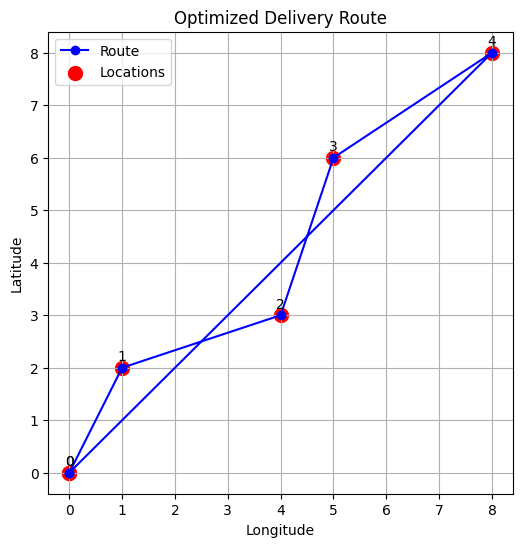

In [ ]:
import matplotlib.pyplot as plt

# Extract the optimized route from the result
optimized_route = result["optimized_route"]

# Get x (longitude) and y (latitude) coordinates from locations
x_coords = [locations[i][0] for i in optimized_route]
y_coords = [locations[i][1] for i in optimized_route]

# Plot the locations and the route
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker="o", linestyle="-", color="b", label="Route")
plt.scatter(x_coords, y_coords, color="red", s=100, label="Locations")

# Annotate points
for i, txt in enumerate(optimized_route):
    plt.annotate(txt, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Delivery Route")
plt.legend()
plt.grid()
plt.show()


In [ ]:
!pip install folium openrouteservice


In [ ]:
pip install polyline


In [ ]:
#using cordinate point
import folium
import requests
import json
import polyline
import itertools  # For route optimization

# OpenRouteService API Key
API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"  # Replace with your key

# Define multiple delivery stops [(Longitude, Latitude)]
coordinates = [
    [77.22905486082311, 28.666814100000003],  # Delhi
    [75.86667439078036, 30.89902896577624],  # Punjab
    [77.0670366, 28.5656109]                 # Gurgaon
]

# OpenRouteService Matrix API endpoint
matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"

# Request payload for distance matrix
payload = {
    "locations": coordinates,
    "metrics": ["duration"],  # Get travel time matrix
    "resolve_locations": False
}

# Headers
headers = {
    "Authorization": API_KEY,
    "Content-Type": "application/json"
}

# Send POST request to get the travel time matrix
response = requests.post(matrix_url, headers=headers, json=payload)
matrix_data = response.json()

# Print the matrix response for debugging
print(json.dumps(matrix_data, indent=4))

# Extract the duration matrix (time in seconds)
if "durations" not in matrix_data:
    raise ValueError("Error: 'durations' key missing in response. Check API key and location format.")

durations = matrix_data["durations"]

# Solve TSP using brute-force (for small sets)
def solve_tsp(matrix):
    num_locations = len(matrix)
    shortest_path = None
    min_time = float('inf')

    for perm in itertools.permutations(range(1, num_locations)):  # Keep first point fixed
        route = [0] + list(perm)  # Always start at first location
        total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

        if total_time < min_time:
            min_time = total_time
            shortest_path = route

    return shortest_path

# Get optimized waypoint order
optimized_order = solve_tsp(durations)
optimized_coordinates = [coordinates[i] for i in optimized_order]

print("Optimized Order:", optimized_order)

# OpenRouteService Directions API endpoint
directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"

# Request payload with optimized order
directions_payload = {
    "coordinates": optimized_coordinates,
    "format": "geojson"
}

# Send POST request for optimized route
directions_response = requests.post(directions_url, headers=headers, json=directions_payload)
route_data = directions_response.json()

# Extract and decode optimized route geometry
route_geometry = route_data["routes"][0]["geometry"]
decoded_polyline = polyline.decode(route_geometry)  # Converts to [(lat, lon), ...]

# Create a Folium map centered at the first coordinate
m = folium.Map(location=optimized_coordinates[0][::-1], zoom_start=7)

# Add the optimized route to the map
folium.PolyLine(decoded_polyline, color="blue", weight=5, opacity=0.8).add_to(m)

# Add markers for each optimized waypoint
for i, coord in enumerate(optimized_coordinates):
    folium.Marker(
        location=coord[::-1],  # Convert (Lon, Lat) to (Lat, Lon)
        popup=f"Stop {i+1}",
        icon=folium.Icon(color="blue" if i != 0 and i != len(optimized_coordinates) - 1 else "red" if i == len(optimized_coordinates) - 1 else "green")
    ).add_to(m)

# Save map to HTML file
m.save("optimized_route_map.html")

# Display the map
m


{
    "durations": [
        [
            0.0,
            13966.47,
            1735.91
        ],
        [
            13968.97,
            0.0,
            13772.63
        ],
        [
            1758.2,
            13749.43,
            0.0
        ]
    ],
    "destinations": [
        {
            "location": [
                77.229377,
                28.666906
            ],
            "snapped_distance": 33.05
        },
        {
            "location": [
                75.866674,
                30.899029
            ]
        },
        {
            "location": [
                77.066786,
                28.565628
            ],
            "snapped_distance": 24.52
        }
    ],
    "sources": [
        {
            "location": [
                77.229377,
                28.666906
            ],
            "snapped_distance": 33.05
        },
        {
            "location": [
                75.866674,
                30.899029
            ]
        },
 

In [ ]:
 #it take location point  and  one way route
import folium
import requests
import json
import polyline
import itertools  # For route optimization

# OpenRouteService API Key
API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"  # Replace with your key

# 1️⃣ **Enter Location Names Instead of Coordinates**
locations = [
    "New Delhi, kashmere gate",      # Start Location
    "D-125, Dron Marg, Shiniwas Puri, Block D, Defence Colon, saket",     # Delivery Point 1
    "Gurgaon, rajiv chawk"         # Delivery Point 2
]

# Function to get coordinates using OpenRouteService Geocoding API
def get_coordinates(location_name):
    geocode_url = f"https://api.openrouteservice.org/geocode/search?api_key={API_KEY}&text={location_name}"
    response = requests.get(geocode_url)
    data = response.json()

    if "features" in data and len(data["features"]) > 0:
        return data["features"][0]["geometry"]["coordinates"]  # Returns (Longitude, Latitude)
    else:
        raise ValueError(f"Error: Could not find coordinates for {location_name}")

# Convert location names to coordinates
coordinates = [get_coordinates(loc) for loc in locations]

# 2️⃣ **Use OpenRouteService Matrix API for Optimization**
matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"
payload = {"locations": coordinates, "metrics": ["duration"]}
headers = {"Authorization": API_KEY, "Content-Type": "application/json"}

response = requests.post(matrix_url, headers=headers, json=payload)
matrix_data = response.json()
durations = matrix_data["durations"]

# 3️⃣ **Solve TSP (Traveling Salesman Problem) to Optimize Route**
def solve_tsp(matrix):
    num_locations = len(matrix)
    shortest_path = None
    min_time = float('inf')

    for perm in itertools.permutations(range(1, num_locations)):  # Keep first point fixed
        route = [0] + list(perm)  # Always start at first location
        total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

        if total_time < min_time:
            min_time = total_time
            shortest_path = route

    return shortest_path

optimized_order = solve_tsp(durations)
optimized_coordinates = [coordinates[i] for i in optimized_order]

# 4️⃣ **Request Optimized Route Directions**
directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"
directions_payload = {"coordinates": optimized_coordinates, "format": "geojson"}

directions_response = requests.post(directions_url, headers=headers, json=directions_payload)
route_data = directions_response.json()

# Decode optimized route
route_geometry = route_data["routes"][0]["geometry"]
decoded_polyline = polyline.decode(route_geometry)  # Converts to [(lat, lon), ...]

# 5️⃣ **Create an Interactive Folium Map**
m = folium.Map(location=optimized_coordinates[0][::-1], zoom_start=7)

# Add the optimized route to the map
folium.PolyLine(decoded_polyline, color="blue", weight=5, opacity=0.8).add_to(m)

# 6️⃣ **Add Numbered Markers for Waypoints**
for i, coord in enumerate(optimized_coordinates):
    folium.Marker(
        location=coord[::-1],  # Convert (Lon, Lat) to (Lat, Lon)
        popup=f"Stop {i+1}: {locations[optimized_order[i]]}",
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: white; background: red; border-radius: 50%; width: 25px; height: 25px; text-align: center; line-height: 25px;">{i+1}</div>')
    ).add_to(m)

# Save map to HTML file
m.save("optimized_route_map.html")

# Display the map
m


In [ ]:
# two way route  proper optmized delivery route
import folium
import requests
import json
import polyline
import itertools  # For route optimization

# OpenRouteService API Key
API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"  # Replace with your key

# 1️⃣ **Enter Location Names Instead of Coordinates**
locations = [
    "New Delhi, delhi",      # Start & End Location
    "Chandigarh, India",     # Delivery Point 1
    "Gurgaon, delhi ncr",    # Delivery Point 2
    "Meerut Cantt, uttar pradesh"
]

# Function to get coordinates using OpenRouteService Geocoding API
def get_coordinates(location_name):
    geocode_url = f"https://api.openrouteservice.org/geocode/search?api_key={API_KEY}&text={location_name}"
    response = requests.get(geocode_url)
    data = response.json()

    if "features" in data and len(data["features"]) > 0:
        return data["features"][0]["geometry"]["coordinates"]  # Returns (Longitude, Latitude)
    else:
        raise ValueError(f"Error: Could not find coordinates for {location_name}")

# Convert location names to coordinates
coordinates = [get_coordinates(loc) for loc in locations]

# 2️⃣ **Use OpenRouteService Matrix API for Optimization**
matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"
payload = {"locations": coordinates, "metrics": ["duration"]}
headers = {"Authorization": API_KEY, "Content-Type": "application/json"}

response = requests.post(matrix_url, headers=headers, json=payload)
matrix_data = response.json()
durations = matrix_data["durations"]

# 3️⃣ **Solve TSP (Traveling Salesman Problem) with Round-Trip Constraint**
def solve_tsp_round_trip(matrix):
    num_locations = len(matrix)
    shortest_path = None
    min_time = float('inf')

    for perm in itertools.permutations(range(1, num_locations)):  # Keep first point fixed
        route = [0] + list(perm) + [0]  # Always start and end at the first location
        total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

        if total_time < min_time:
            min_time = total_time
            shortest_path = route

    return shortest_path

optimized_order = solve_tsp_round_trip(durations)
optimized_coordinates = [coordinates[i] for i in optimized_order]

# 4️⃣ **Request Optimized Route Directions**
directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"
directions_payload = {"coordinates": optimized_coordinates, "format": "geojson"}

directions_response = requests.post(directions_url, headers=headers, json=directions_payload)
route_data = directions_response.json()

# Decode optimized route
route_geometry = route_data["routes"][0]["geometry"]
decoded_polyline = polyline.decode(route_geometry)  # Converts to [(lat, lon), ...]

# 5️⃣ **Create an Interactive Folium Map**
m = folium.Map(location=optimized_coordinates[0][::-1], zoom_start=7)

# Add the optimized route to the map
folium.PolyLine(decoded_polyline, color="blue", weight=5, opacity=0.8).add_to(m)

# 6️⃣ **Add Numbered Markers for Waypoints (Avoiding Last Duplicate Marker)**
for i, coord in enumerate(optimized_coordinates[:-1]):  # Skip the last one (same as first)
    marker_number = 1 if i == 0 else i + 1  # First location is always "1"

    folium.Marker(
        location=coord[::-1],  # Convert (Lon, Lat) to (Lat, Lon)
        popup=f"Stop {marker_number}: {locations[optimized_order[i]]}",
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: white; background: red; border-radius: 50%; width: 25px; height: 25px; text-align: center; line-height: 25px;">{marker_number}</div>')
    ).add_to(m)

# Save map to HTML file
m.save("optimized_round_trip_map.html")

# Display the map
m


In [ ]:

from flask import Flask, request, jsonify
import requests
import polyline
import itertools  # For route optimization



# OpenRouteService API Key
API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"  # Replace with your own API key



import requests

# Server URL
URL = "http://localhost:5001/deliveries"

def fetch_deliveries():
    try:
        # Make GET request to fetch data
        response = requests.get(URL)
        response.raise_for_status()  # Raise error for bad responses (4xx, 5xx)

        # Parse JSON response
        data = response.json()

        # Process data (Example: Print all deliveries)
        for delivery in data:
            print(f"Delivery ID: {delivery.get('id', 'N/A')}")
            print(f"Location: {delivery.get('coordinates', 'Unknown')}")
            print(f"Items: {', '.join(delivery.get('items', []))}")
            print("-" * 30)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")

if __name__ == "__main__":
    fetch_deliveries()








# Get optimized route based on coordinates
def get_optimized_route(coordinates):
    matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"
    headers = {"Authorization": API_KEY, "Content-Type": "application/json"}

    # Step 1: Get the distance matrix
    response = requests.post(matrix_url, headers=headers, json={"locations": coordinates, "metrics": ["duration"]})
    matrix_data = response.json()
    durations = matrix_data["durations"]

    # Step 2: Solve TSP (Traveling Salesman Problem) with a round-trip
    def solve_tsp_round_trip(matrix):
        num_locations = len(matrix)
        shortest_path = None
        min_time = float('inf')

        for perm in itertools.permutations(range(1, num_locations)):  # Keep first point fixed
            route = [0] + list(perm) + [0]  # Always start and end at the first location
            total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

            if total_time < min_time:
                min_time = total_time
                shortest_path = route

        return shortest_path

    optimized_order = solve_tsp_round_trip(durations)
    optimized_coordinates = [coordinates[i] for i in optimized_order]

    # Step 3: Get optimized route path
    directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"
    directions_response = requests.post(directions_url, headers=headers, json={"coordinates": optimized_coordinates, "format": "geojson"})
    route_data = directions_response.json()

    # Decode the optimized route polyline
    route_geometry = route_data["routes"][0]["geometry"]
    decoded_polyline = polyline.decode(route_geometry)  # Converts to [(lat, lon), ...]

    return {"optimized_route": decoded_polyline, "waypoints": optimized_coordinates}

# API endpoint to receive coordinates from React and return optimized route
@app.route("/optimize-route", methods=["POST"])
def optimize_route():
    data = request.json
    delivery_points = data.get("coordinates", [])

    if not delivery_points or len(delivery_points) < 2:
        return jsonify({"error": "At least two locations are required"}), 400

    optimized_data = get_optimized_route(delivery_points)
    return jsonify(optimized_data)

if __name__ == "__main__":
    app.run(debug=True, port=5001)


Error fetching data: HTTPConnectionPool(host='localhost', port=5001): Max retries exceeded with url: /deliveries (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7816c15cd290>: Failed to establish a new connection: [Errno 111] Connection refused'))


NameError: name 'app' is not defined

In [ ]:
# heat map of delhi of state on the bases of population
import folium
from folium.plugins import HeatMap

# Heatmap ke liye latitude & longitude points
heatmap_data = [
  # coordinates
    [28.6139, 77.2090],  # Delhi (Union Territory)
    [19.0760, 72.8777],  # Mumbai, Maharashtra
    [13.0827, 80.2707],  # Chennai, Tamil Nadu
    [22.5726, 88.3639],  # Kolkata, West Bengal
    [26.8467, 80.9462],  # Lucknow, Uttar Pradesh
    [12.9716, 77.5946],  # Bangalore, Karnataka
    [17.3850, 78.4867],  # Hyderabad, Telangana
    [25.5941, 85.1376],  # Patna, Bihar
    [30.7333, 76.7794],  # Chandigarh (Union Territory & Punjab, Haryana capital)
    [23.2599, 77.4126],  # Bhopal, Madhya Pradesh
    [11.0168, 76.9558],  # Thiruvananthapuram, Kerala
    [15.2993, 74.1240],  # Panaji, Goa
    [30.9010, 75.8573],  # Ludhiana, Punjab
    [31.1048, 77.1734],  # Shimla, Himachal Pradesh
    [27.4728, 89.6391],  # Gangtok, Sikkim
    [15.8281, 78.0373],  # Amaravati, Andhra Pradesh
    [34.0837, 74.7973],  # Srinagar, Jammu & Kashmir (Summer Capital)
    [32.7266, 74.8570],  # Jammu, Jammu & Kashmir (Winter Capital)
    [26.2006, 92.9376],  # Dispur, Assam
    [23.8315, 91.2868],  # Agartala, Tripura
    [27.3306, 88.6138],  # Gangtok, Sikkim
    [25.5788, 91.8933],  # Shillong, Meghalaya
    [24.8170, 93.9368],  # Imphal, Manipur
    [27.0912, 93.6053],  # Itanagar, Arunachal Pradesh
    [25.5700, 91.8807],  # Shillong, Meghalaya
    [25.6747, 94.1100],  # Kohima, Nagaland
    [23.1645, 92.9376],  # Aizawl, Mizoram
    [20.2961, 85.8245],  # Bhubaneswar, Odisha
    [21.1458, 79.0882],  # Nagpur, Maharashtra (Winter Capital)
    [26.1445, 91.7362],  # Guwahati, Assam
    [22.7196, 75.8577],  # Indore, Madhya Pradesh
    [24.5854, 73.7125],  # Udaipur, Rajasthan
    [26.9124, 75.7873],  # Jaipur, Rajasthan
    [21.1702, 72.8311],  # Gandhinagar, Gujarat
    [11.9416, 79.8083],  # Puducherry (Union Territory)
    [9.9252, 78.1198],   # Madurai, Tamil Nadu
    [8.5241, 76.9366],   # Thiruvananthapuram, Kerala
    [12.2958, 76.6394],  # Mysore, Karnataka
    [19.7515, 75.7139],  # Aurangabad, Maharashtra
]

#  Map initialize kar (India ke center pe zoom)
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Heatmap add kar
HeatMap(heatmap_data, radius=25, blur=15).add_to(m)

#  Colab ke andar hi map show kar
m

In [ ]:
# heat map for delivery cordinates
import folium
import requests
import json
import polyline
from folium.plugins import HeatMap
import itertools  # For route optimization

# OpenRouteService API Key
API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"  # Replace with your API key

# Delivery Locations (Addresses)
locations = [
    "New Delhi, India",      # Start & End Location
    "Chandigarh, India",     # Delivery Point 1
    "Gurgaon, India",        # Delivery Point 2
    "Meerut, India"          # Delivery Point 3
]

# Function to get coordinates using OpenRouteService Geocoding API
def get_coordinates(location_name):
    geocode_url = f"https://api.openrouteservice.org/geocode/search?api_key={API_KEY}&text={location_name}"
    response = requests.get(geocode_url)
    data = response.json()

    if "features" in data and len(data["features"]) > 0:
        return data["features"][0]["geometry"]["coordinates"]  # Returns (Longitude, Latitude)
    else:
        raise ValueError(f"Error: Could not find coordinates for {location_name}")

# Convert location names to coordinates
coordinates = [get_coordinates(loc) for loc in locations]

# Get Distance Matrix for Route Optimization
matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"
payload = {"locations": coordinates, "metrics": ["duration"]}
headers = {"Authorization": API_KEY, "Content-Type": "application/json"}
response = requests.post(matrix_url, headers=headers, json=payload)
matrix_data = response.json()
durations = matrix_data["durations"]

# Solve TSP (Traveling Salesman Problem) for Optimization
def solve_tsp_round_trip(matrix):
    num_locations = len(matrix)
    shortest_path = None
    min_time = float('inf')

    for perm in itertools.permutations(range(1, num_locations)):  # Keep first point fixed
        route = [0] + list(perm) + [0]  # Always start and end at first location
        total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

        if total_time < min_time:
            min_time = total_time
            shortest_path = route

    return shortest_path

optimized_order = solve_tsp_round_trip(durations)
optimized_coordinates = [coordinates[i] for i in optimized_order]

# Request Optimized Route Directions
directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"
directions_payload = {"coordinates": optimized_coordinates, "format": "geojson"}
directions_response = requests.post(directions_url, headers=headers, json=directions_payload)
route_data = directions_response.json()

# Decode Optimized Route
route_geometry = route_data["routes"][0]["geometry"]
decoded_polyline = polyline.decode(route_geometry)  # Converts to [(lat, lon), ...]

# Create Map with Heatmap Layer
m = folium.Map(location=optimized_coordinates[0][::-1], zoom_start=7)

# Add Optimized Route to Map
folium.PolyLine(decoded_polyline, color="blue", weight=5, opacity=0.8).add_to(m)

# Add Numbered Markers for Waypoints
for i, coord in enumerate(optimized_coordinates[:-1]):  # Skip last duplicate marker
    marker_number = 1 if i == 0 else i + 1  # First location is always "1"
    folium.Marker(
        location=coord[::-1],  # Convert (Lon, Lat) to (Lat, Lon)
        popup=f"Stop {marker_number}: {locations[optimized_order[i]]}",
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: white; background: red; border-radius: 50%; width: 25px; height: 25px; text-align: center; line-height: 25px;">{marker_number}</div>')
    ).add_to(m)

# Add Heatmap Layer
heat_data = [coord[::-1] for coord in coordinates]  # Convert (Lon, Lat) to (Lat, Lon)
HeatMap(heat_data, radius=25).add_to(m)

# Save Map to HTML File
m.save("optimized_route_heatmap.html")

# Display the Map
m


In [ ]:
# route provide over static traffic data
from google.colab import files
import pandas as pd
import itertools
import random

# Upload the file manually
uploaded = files.upload()

# Get the filename dynamically
file_name = list(uploaded.keys())[0]

# Load the CSV into a DataFrame
df = pd.read_csv(file_name)

# Display dataset info
print("Dataset Info:")
df.info()

# Show the first few rows
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Function to get travel time between two locations at a specific time
def get_travel_time(start, end, time_of_day):
    row = df[(df['location_start'] == start) & (df['location_end'] == end) & (df['time_of_day'] == time_of_day)]
    return row['average_travel_time'].values[0] if not row.empty else float('inf')

# Get user input for locations and time of day
print("\nAvailable locations:", df['location_start'].unique())
locations = []
num_locations = int(input("Enter the number of locations you want to visit: "))
for i in range(num_locations):
    loc = input(f"Enter location {i+1}: ")
    locations.append(loc)

time_of_day = input("Enter time of day (Morning/Afternoon/Evening/Night): ")

# Generate all possible orders of visiting locations
best_order = None
min_travel_time = float('inf')

for perm in itertools.permutations(locations):
    total_time = sum(get_travel_time(perm[i], perm[i+1], time_of_day) for i in range(len(perm)-1))
    if total_time < min_travel_time:
        min_travel_time = total_time
        best_order = perm

# Generate a random order for comparison
random_order = random.sample(locations, len(locations))
rnd_travel_time = sum(get_travel_time(random_order[i], random_order[i+1], time_of_day) for i in range(len(random_order)-1))

time_saved = max(0, rnd_travel_time - min_travel_time)

# Display the best sequence and time saved
print("\nOptimal visiting order:", best_order)
print("Total estimated travel time:", min_travel_time, "minutes")
print("\nRandom visiting order:", random_order)
print("Total travel time for random order:", rnd_travel_time, "minutes")
print("\nTime saved by optimal route:", time_saved, "minutes")

Saving delhi_traffic_data.csv to delhi_traffic_data (1).csv
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   location_start       360 non-null    object
 1   location_end         360 non-null    object
 2   time_of_day          360 non-null    object
 3   average_travel_time  360 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 11.4+ KB

First few rows:
  location_start     location_end time_of_day  average_travel_time
0   Lajpat Nagar    Chandni Chowk     Morning                   32
1   Lajpat Nagar    Chandni Chowk   Afternoon                   20
2   Lajpat Nagar    Chandni Chowk     Evening                   27
3   Lajpat Nagar    Chandni Chowk       Night                   15
4   Lajpat Nagar  Connaught Place     Morning                   43

Missing values:
location_start         0
location_end    

In [ ]:
pip install polyline


In [ ]:
import folium
import requests
import json
import polyline
import itertools

# OpenRouteService API Key
ORS_API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"  # Replace with your ORS API Key
TOMTOM_API_KEY = "oGZM1Ja1Viaq64NoLb24AERrhyAJ6G0j"  # Replace with your TomTom API Key

# Location names
locations = [
    "New Delhi, Kashmere Gate",
    "D-125, Dron Marg, Shiniwas Puri, Block D, Defence Colon, Saket",
    "Gurgaon, Rajiv Chowk"
]

# Function to get coordinates from ORS
def get_coordinates(location_name):
    geocode_url = f"https://api.openrouteservice.org/geocode/search?api_key={ORS_API_KEY}&text={location_name}"
    response = requests.get(geocode_url)
    data = response.json()

    if "features" in data and len(data["features"]) > 0:
        return data["features"][0]["geometry"]["coordinates"]  # (Longitude, Latitude)
    else:
        raise ValueError(f"Error: Could not find coordinates for {location_name}")

# Convert location names to coordinates
coordinates = [get_coordinates(loc) for loc in locations]

# Solve TSP (Optimized Route)
def solve_tsp(matrix):
    num_locations = len(matrix)
    shortest_path = None
    min_time = float('inf')

    for perm in itertools.permutations(range(1, num_locations)):  # Keep first point fixed
        route = [0] + list(perm)
        total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

        if total_time < min_time:
            min_time = total_time
            shortest_path = route

    return shortest_path

# Get optimized route from ORS Matrix API
matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"
payload = {"locations": coordinates, "metrics": ["duration"]}
headers = {"Authorization": ORS_API_KEY, "Content-Type": "application/json"}

response = requests.post(matrix_url, headers=headers, json=payload)
matrix_data = response.json()
durations = matrix_data["durations"]

optimized_order = solve_tsp(durations)
optimized_coordinates = [coordinates[i] for i in optimized_order]

# Request optimized route directions
directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"
directions_payload = {"coordinates": optimized_coordinates, "format": "geojson"}

directions_response = requests.post(directions_url, headers=headers, json=directions_payload)
route_data = directions_response.json()
route_geometry = route_data["routes"][0]["geometry"]
decoded_polyline = polyline.decode(route_geometry)  # Convert to [(lat, lon), ...]

# Create Folium map
m = folium.Map(location=optimized_coordinates[0][::-1], zoom_start=10)

# Add TomTom Traffic Layer
# folium.TileLayer(
#     tiles=f"https://api.tomtom.com/map/1/tile/basic/main/{z}/{x}/{y}.png?key={TOMTOM_API_KEY}",
#     attr="TomTom Traffic",
#     name="TomTom Traffic",
#     overlay=True
# ).add_to(m)

 # Add TomTom Traffic Layer
folium.TileLayer(
    tiles=f"https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json?key=oGZM1Ja1Viaq64NoLb24AERrhyAJ6G0j&point=52.41072,4.84239",
    attr="TomTom Traffic",
    name="TomTom Traffic",
    overlay=True
).add_to(m)


# Add Route to Map
folium.PolyLine(decoded_polyline, color="blue", weight=5, opacity=0.8).add_to(m)

# Add Numbered Markers for Waypoints
for i, coord in enumerate(optimized_coordinates):
    folium.Marker(
        location=coord[::-1],
        popup=f"Stop {i+1}: {locations[optimized_order[i]]}",
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: white; background: red; border-radius: 50%; width: 25px; height: 25px; text-align: center; line-height: 25px;">{i+1}</div>')
    ).add_to(m)

# Add Layer Control
folium.LayerControl().add_to(m)

# Save and display the map
m.save("optimized_route_map_with_traffic.html")
m


In [ ]:
import folium
import requests
import json
import polyline
import itertools  # For route optimization

# API Keys
ORS_API_KEY = "5b3ce3597851110001cf624823f388c1e7b64b029159e7e12b9ceaa6"
TOMTOM_API_KEY = "oGZM1Ja1Viaq64NoLb24AERrhyAJ6G0j"

# 📍 **Enter Location Names**
locations = [
    "New Delhi, kashmere gate",
    # "D-125, Dron Marg, Shiniwas Puri, Block D, Defence Colon, saket",
    # "Gurgaon, rajiv chawk"
    "Sector 28 Dwarka, South City I, Sector 30, Gurugram, Haryana 122001",
    "Basanti Marg, H Block, Chauma Village, Sector 1, Palam Vihar, Gurugram, Haryana 122017, lajpat nagar"
]

# 🔎 **Convert Location Names to Coordinates**
def get_coordinates(location_name):
    geocode_url = f"https://api.openrouteservice.org/geocode/search?api_key={ORS_API_KEY}&text={location_name}"
    response = requests.get(geocode_url)
    data = response.json()

    if "features" in data and len(data["features"]) > 0:
        return data["features"][0]["geometry"]["coordinates"]  # (Longitude, Latitude)
    else:
        raise ValueError(f"Error: Could not find coordinates for {location_name}")

coordinates = [get_coordinates(loc) for loc in locations]

# 🛣️ **Optimize Route with OpenRouteService Matrix API**
matrix_url = "https://api.openrouteservice.org/v2/matrix/driving-car"
payload = {"locations": coordinates, "metrics": ["duration"]}
headers = {"Authorization": ORS_API_KEY, "Content-Type": "application/json"}

response = requests.post(matrix_url, headers=headers, json=payload)
matrix_data = response.json()
durations = matrix_data["durations"]

# 🔀 **Solve TSP (Route Optimization)**
def solve_tsp(matrix):
    num_locations = len(matrix)
    shortest_path = None
    min_time = float('inf')

    for perm in itertools.permutations(range(1, num_locations)):
        route = [0] + list(perm)
        total_time = sum(matrix[route[i]][route[i + 1]] for i in range(len(route) - 1))

        if total_time < min_time:
            min_time = total_time
            shortest_path = route

    return shortest_path

optimized_order = solve_tsp(durations)
optimized_coordinates = [coordinates[i] for i in optimized_order]

# 📌 **Request Optimized Route Directions**
directions_url = "https://api.openrouteservice.org/v2/directions/driving-car"
directions_payload = {"coordinates": optimized_coordinates, "format": "geojson"}

directions_response = requests.post(directions_url, headers=headers, json=directions_payload)
route_data = directions_response.json()

# 🔍 **Decode Route Polyline**
route_geometry = route_data["routes"][0]["geometry"]
decoded_polyline = polyline.decode(route_geometry)  # List of (lat, lon) tuples

# 🗺️ **Create Interactive Folium Map**
m = folium.Map(location=optimized_coordinates[0][::-1], zoom_start=10)

# 🚦 **Fetch Real-Time Traffic Data and Color Route**
colored_route = []  # Store segments with colors

for i in range(len(decoded_polyline) - 1):
    lat1, lon1 = decoded_polyline[i]
    lat2, lon2 = decoded_polyline[i + 1]

    # Fetch real-time traffic data for segment
    traffic_url = f"https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json?key={TOMTOM_API_KEY}&point={lat1},{lon1}"
    traffic_response = requests.get(traffic_url)
    traffic_data = traffic_response.json()

    if "flowSegmentData" in traffic_data:
        current_speed = traffic_data["flowSegmentData"]["currentSpeed"]
        free_flow_speed = traffic_data["flowSegmentData"]["freeFlowSpeed"]

        # Determine color based on traffic congestion
        speed_ratio = current_speed / free_flow_speed if free_flow_speed > 0 else 1
        if speed_ratio >= 0.8:
            color = "green"  # Free flow
        elif speed_ratio >= 0.4:
            color = "orange"  # Moderate traffic
        else:
            color = "red"  # Heavy congestion

        # Store segment with color
        colored_route.append(((lat1, lon1), (lat2, lon2), color))

# 🚗 **Add Colored Route to Map**
for (start, end, color) in colored_route:
    folium.PolyLine([start, end], color=color, weight=5, opacity=0.8).add_to(m)

# 🔴 **Add Markers for Stops**
for i, coord in enumerate(optimized_coordinates):
    folium.Marker(
        location=coord[::-1],
        popup=f"Stop {i+1}: {locations[optimized_order[i]]}",
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: white; background: red; border-radius: 50%; width: 25px; height: 25px; text-align: center; line-height: 25px;">{i+1}</div>')
    ).add_to(m)

# 🗺 **Save and Display Map**
m.save("optimized_route_with_traffic.html")
m
